In [ ]:
#creating each subject and group level matrices
import os
import sys
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import image, input_data
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Atlas paths
atlas_path = f'{curr_dir}/glasser/HCP-MMP1_on_MNI152_ICBM2009a_nlin.nii.gz'
labels_path = f'{curr_dir}/glasser/HCP-MMP1_on_MNI152_ICBM2009a_nlin.txt'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

run_num = 3
runs = list(range(1, run_num + 1))

def read_glasser_labels(labels_path):
    """Read and parse the Glasser atlas labels file"""
    try:
        with open(labels_path, 'r') as f:
            lines = f.readlines()
            # Parse labels file - structure depends on the file format
            # We'll need to adjust this based on the actual content of your .txt file
            labels = [line.strip() for line in lines if line.strip()]
        logging.info(f"Loaded {len(labels)} region labels")
        return labels
    except Exception as e:
        logging.error(f"Error reading labels file: {e}")
        return None

def apply_glasser_atlas(subject_data, atlas_img):
    # Resample atlas to subject space
    resampled_atlas = image.resample_to_img(atlas_img, subject_data, interpolation='nearest')
    
    # Extract time series data
    atlas_masker = NiftiLabelsMasker(labels_img=resampled_atlas, 
                                    standardize=True,
                                    memory='nilearn_cache', 
                                    verbose=0)
    time_series = atlas_masker.fit_transform(subject_data)
    
    return time_series

def create_connectivity_matrix(ss):
    logging.info(f"Processing subject: {ss}")
    
    # Load Glasser atlas
    atlas_img = nib.load(atlas_path)
    logging.info(f"Loaded Glasser atlas with shape: {atlas_img.shape}")
    
    all_runs_data = []
    
    for rn in runs:
        # Load subject data for this run
        run_path = f'{raw_dir}/{ss}/ses-01/derivatives/fsl/loc/run-0{rn}/1stLevel.feat/reg_standard/filtered_func_data_standard.nii.gz'
        if not os.path.exists(run_path):
            logging.warning(f'Run data not found: {run_path}')
            continue
        
        subject_img = nib.load(run_path)
        logging.info(f"Loaded run {rn} with shape: {subject_img.shape}")
        
        # Apply atlas and extract time series
        run_data = apply_glasser_atlas(subject_img, atlas_img)
        logging.info(f"Extracted time series with shape: {run_data.shape}")
        all_runs_data.append(run_data)
    
    if not all_runs_data:
        logging.warning(f'No valid run data found for subject {ss}')
        return None
    
    # Concatenate runs
    full_time_series = np.concatenate(all_runs_data, axis=0)
    
    # Compute connectivity matrix
    correlation_measure = ConnectivityMeasure(kind='correlation')
    connectivity_matrix = correlation_measure.fit_transform([full_time_series])[0]
    logging.info(f"Created {connectivity_matrix.shape} connectivity matrix")
    
    return connectivity_matrix

def calculate_group_matrices():
    all_matrices = []
    
    for ss in subs:
        matrix_path = f'{results_dir}/connectivity_matrices/{ss}_glasser_connectivity_matrix.npy'
        if os.path.exists(matrix_path):
            matrix = np.load(matrix_path)
            all_matrices.append(matrix)
    
    if all_matrices:
        # Calculate mean and std matrices
        all_matrices = np.array(all_matrices)
        mean_matrix = np.mean(all_matrices, axis=0)
        std_matrix = np.std(all_matrices, axis=0)
        
        # Save group-level matrices
        output_dir = f'{results_dir}/connectivity_data'
        os.makedirs(output_dir, exist_ok=True)
        np.save(f'{output_dir}/glasser_group_mean_matrix.npy', mean_matrix)
        np.save(f'{output_dir}/glasser_group_std_matrix.npy', std_matrix)
        logging.info('Saved group-level matrices')

def main():
    # Load atlas labels
    labels = read_glasser_labels(labels_path)
    if labels is None:
        logging.warning("Proceeding without labels")
    
    # Create individual connectivity matrices
    for ss in subs:
        connectivity_matrix = create_connectivity_matrix(ss)
        if connectivity_matrix is not None:
            # Save the connectivity matrix
            output_dir = f'{results_dir}/connectivity_matrices'
            os.makedirs(output_dir, exist_ok=True)
            np.save(f'{output_dir}/{ss}_glasser_connectivity_matrix.npy', connectivity_matrix)
            logging.info(f'Saved connectivity matrix for {ss}')
    
    # Calculate and save group-level matrices
    calculate_group_matrices()

if __name__ == "__main__":
    main()

2024-10-25 17:54:15,739 - INFO - Loaded 180 region labels
2024-10-25 17:54:15,741 - INFO - Processing subject: sub-025
2024-10-25 17:54:15,744 - INFO - Loaded Glasser atlas with shape: (197, 233, 189)
2024-10-25 17:54:15,966 - INFO - Loaded run 1 with shape: (176, 256, 256, 184)
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/maskers/nifti_labels_masker.py:614: UserWarning: Persisting input arguments took 12.03s to run.
If this happens often in your code, it can

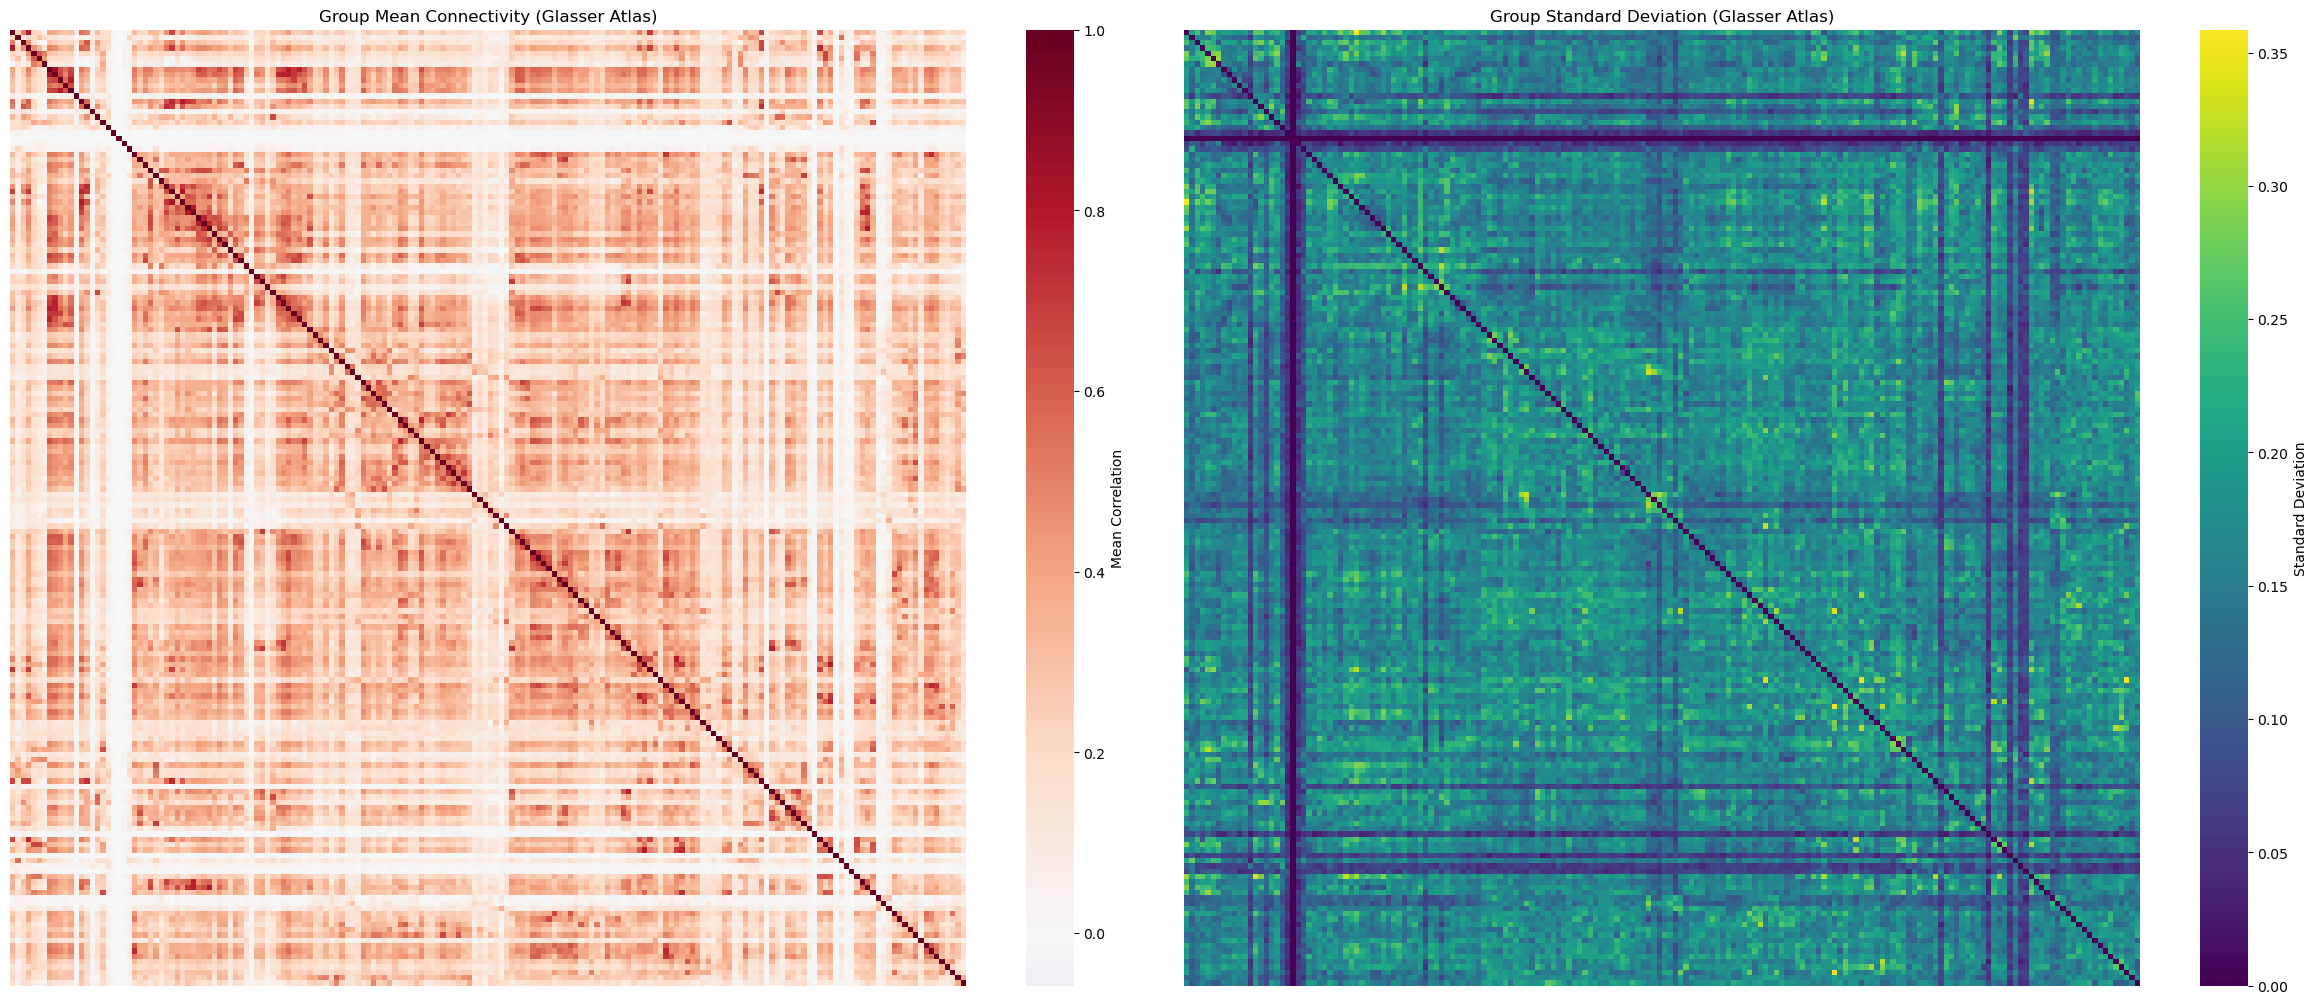


Connectivity Statistics:
Mean correlation range: -0.058 to 1.000
Average correlation: 0.230
Standard deviation range: 0.000 to 0.359


In [1]:
# plotting the group level matrices
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def read_glasser_labels(labels_path):
    """Read Glasser atlas labels"""
    with open(labels_path, 'r') as f:
        # Read lines and extract ROI names, skip the number at start of each line
        labels = [line.split('_ROI')[0].split(' ', 1)[1] for line in f.readlines()]
    return labels

def visualize_connectivity():
    # Paths
    curr_dir = '/user_data/csimmon2/git_repos/ptoc'
    results_dir = f'{curr_dir}/results'
    labels_path = f'{curr_dir}/glasser/HCP-MMP1_on_MNI152_ICBM2009a_nlin.txt'
    
    # Load matrices
    mean_matrix = np.load(f'{results_dir}/connectivity_data/glasser_group_mean_matrix.npy')
    std_matrix = np.load(f'{results_dir}/connectivity_data/glasser_group_std_matrix.npy')
    
    # Load and process labels
    labels = read_glasser_labels(labels_path)
    
    # Create figure with subplots for mean and std matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    
    # Plot mean matrix
    sns.heatmap(mean_matrix, 
                cmap='RdBu_r',
                center=0,
                square=True,
                ax=ax1,
                xticklabels=False,
                yticklabels=False,
                cbar_kws={'label': 'Mean Correlation'})
    ax1.set_title('Group Mean Connectivity (Glasser Atlas)')
    
    # Plot std matrix
    sns.heatmap(std_matrix, 
                cmap='viridis',
                square=True,
                ax=ax2,
                xticklabels=False,
                yticklabels=False,
                cbar_kws={'label': 'Standard Deviation'})
    ax2.set_title('Group Standard Deviation (Glasser Atlas)')
    
    plt.tight_layout()
    plt.show()
    
    # Print some basic statistics
    print("\nConnectivity Statistics:")
    print(f"Mean correlation range: {mean_matrix.min():.3f} to {mean_matrix.max():.3f}")
    print(f"Average correlation: {mean_matrix.mean():.3f}")
    print(f"Standard deviation range: {std_matrix.min():.3f} to {std_matrix.max():.3f}")
    
    # Create network-level summary if needed
    # We can add this based on your needs

if __name__ == "__main__":
    visualize_connectivity()

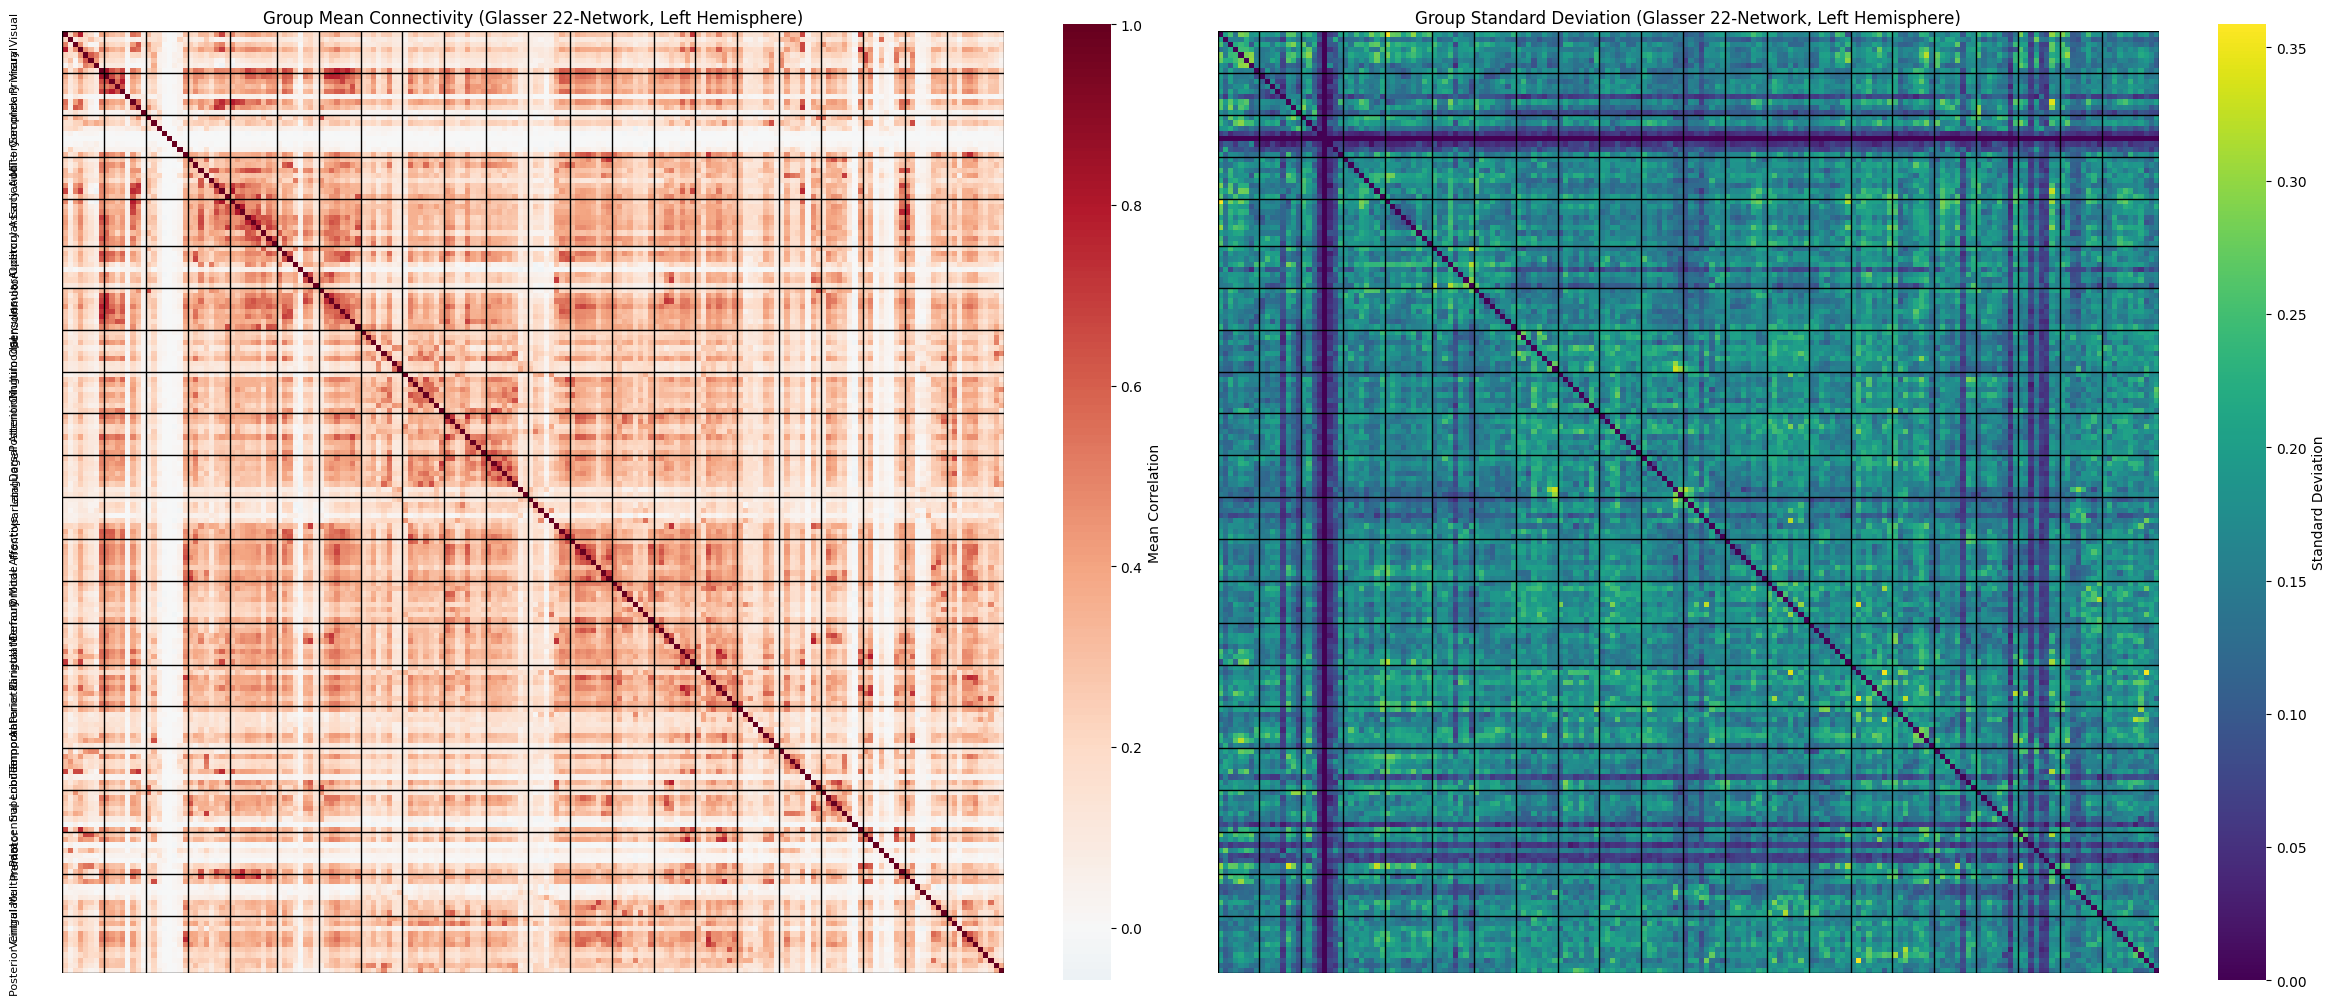

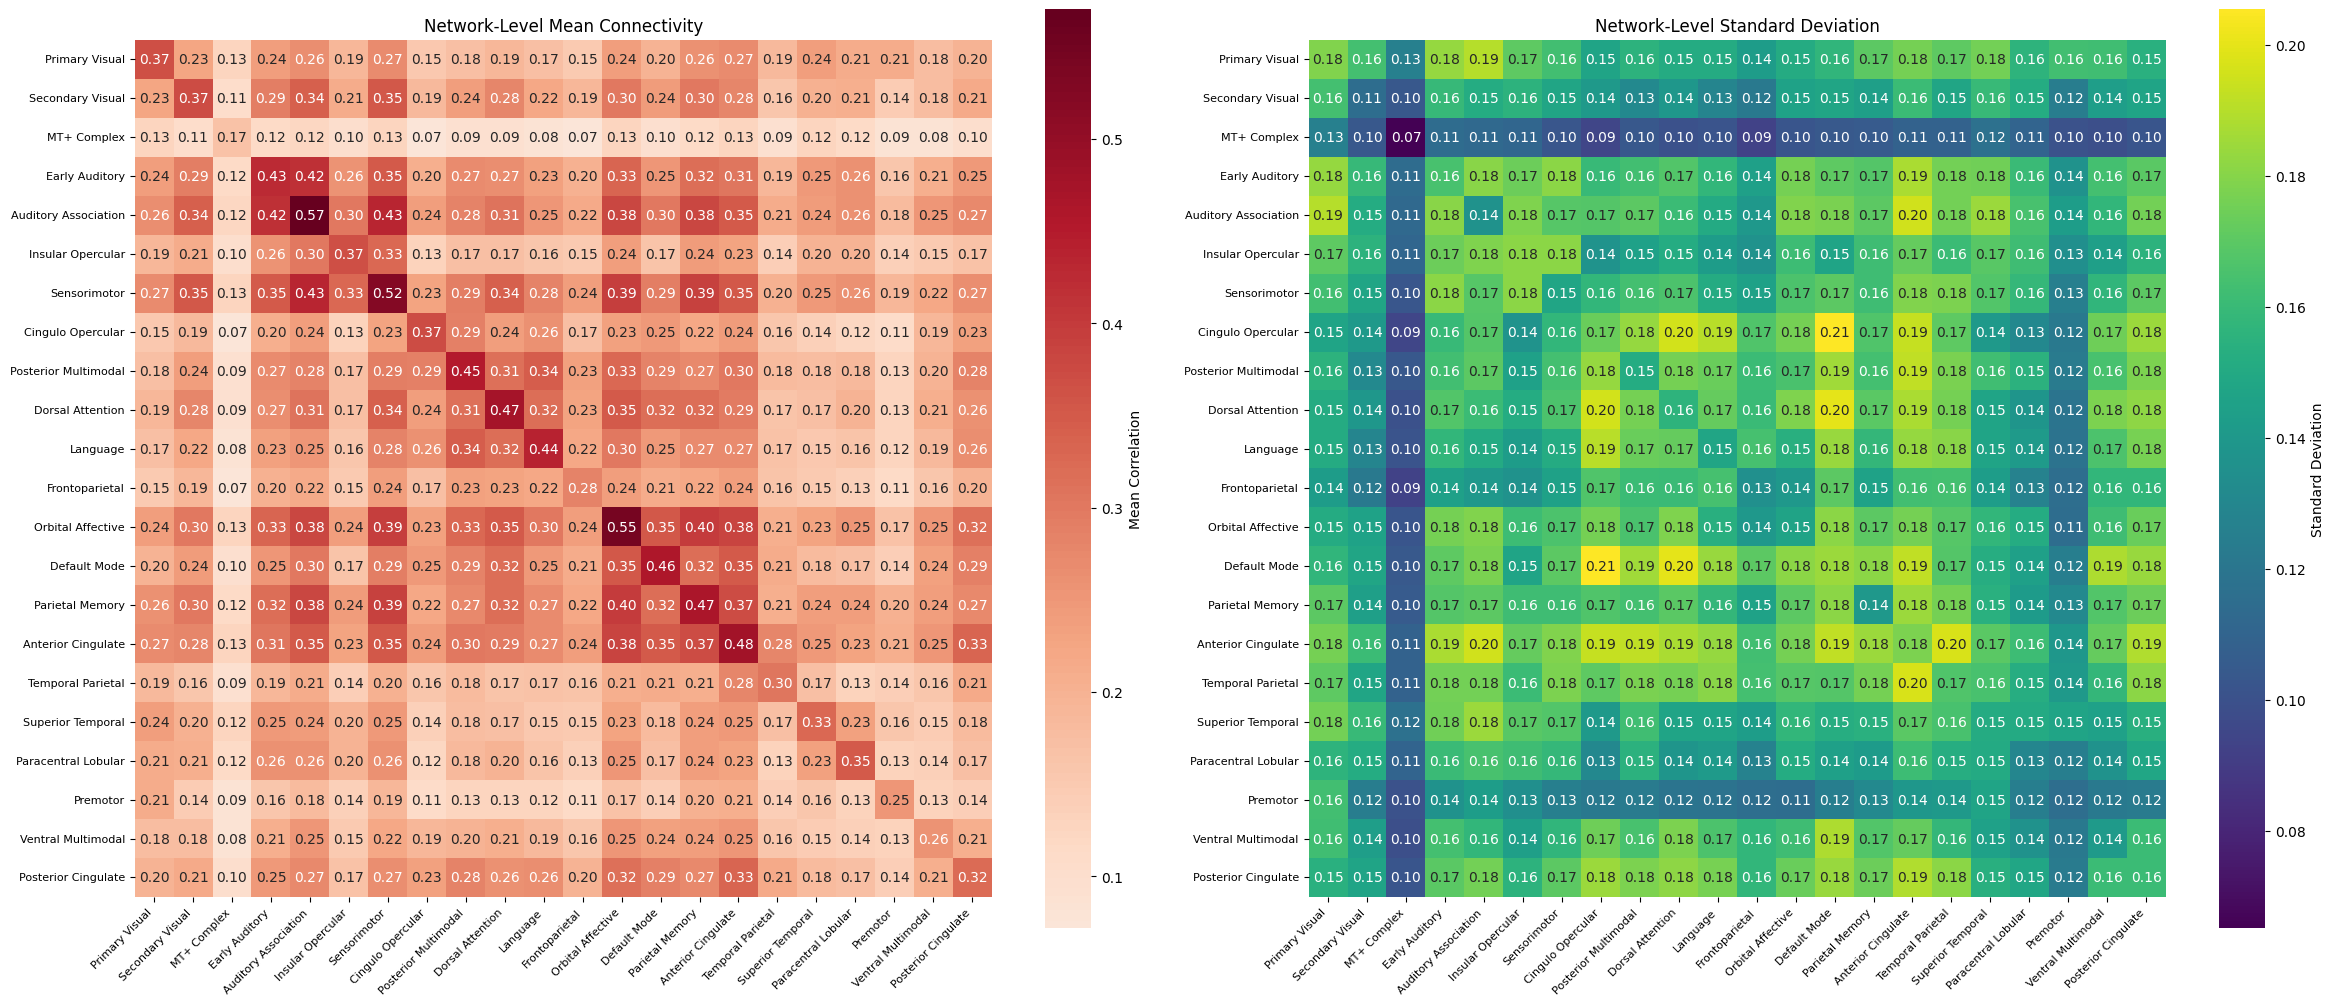

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_22_networks():
    # Paths
    curr_dir = '/user_data/csimmon2/git_repos/ptoc'
    results_dir = f'{curr_dir}/results'
    
    # Load matrices
    mean_matrix = np.load(f'{results_dir}/connectivity_data/glasser_group_mean_matrix.npy')
    std_matrix = np.load(f'{results_dir}/connectivity_data/glasser_group_std_matrix.npy')
    
    # Adjusted network boundaries for 180 regions (half of 360)
    networks = [0, 8, 16, 24, 32, 41, 49, 57, 65, 73, 81, 89, 97, 105, 113, 121, 129, 137, 145, 153, 161, 169, 180]
    
    network_labels = [
        'Primary Visual',
        'Secondary Visual',
        'MT+ Complex',
        'Early Auditory',
        'Auditory Association',
        'Insular Opercular',
        'Sensorimotor',
        'Cingulo Opercular',
        'Posterior Multimodal',
        'Dorsal Attention',
        'Language',
        'Frontoparietal',
        'Orbital Affective',
        'Default Mode',
        'Parietal Memory',
        'Anterior Cingulate',
        'Temporal Parietal',
        'Superior Temporal',
        'Paracentral Lobular',
        'Premotor',
        'Ventral Multimodal',
        'Posterior Cingulate'
    ]
    
    # Create figure with subplots for mean and std matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    
    # Plot mean matrix
    sns.heatmap(mean_matrix, 
                cmap='RdBu_r',
                center=0,
                square=True,
                ax=ax1,
                xticklabels=False,
                yticklabels=False,
                cbar_kws={'label': 'Mean Correlation'})
    ax1.set_title('Group Mean Connectivity (Glasser 22-Network, Left Hemisphere)')
    
    # Add network boundaries and labels to mean matrix
    for idx in networks:
        ax1.axhline(y=idx, color='black', linewidth=1)
        ax1.axvline(x=idx, color='black', linewidth=1)
    
    # Add network labels
    for i in range(len(networks)-1):
        mid_point = (networks[i] + networks[i+1]) // 2
        ax1.text(-10, mid_point, network_labels[i],
                rotation=90, verticalalignment='center', fontsize=8)
    
    # Plot std matrix
    sns.heatmap(std_matrix, 
                cmap='viridis',
                square=True,
                ax=ax2,
                xticklabels=False,
                yticklabels=False,
                cbar_kws={'label': 'Standard Deviation'})
    ax2.set_title('Group Standard Deviation (Glasser 22-Network, Left Hemisphere)')
    
    # Add network boundaries to std matrix
    for idx in networks:
        ax2.axhline(y=idx, color='black', linewidth=1)
        ax2.axvline(x=idx, color='black', linewidth=1)
    
    plt.tight_layout()
    plt.show()
    
    # Create network-level summary matrices
    network_means = np.zeros((len(network_labels), len(network_labels)))
    network_stds = np.zeros((len(network_labels), len(network_labels)))

    for i in range(len(networks)-1):
        for j in range(len(networks)-1):
            block_mean = mean_matrix[networks[i]:networks[i+1], networks[j]:networks[j+1]].mean()
            block_std = std_matrix[networks[i]:networks[i+1], networks[j]:networks[j+1]].mean()
            network_means[i,j] = block_mean
            network_stds[i,j] = block_std

    # Plot network-level summaries
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    # Network-level mean connectivity
    sns.heatmap(network_means, 
                cmap='RdBu_r',
                center=0,
                square=True,
                ax=ax1,
                xticklabels=network_labels,
                yticklabels=network_labels,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Mean Correlation'})
    ax1.set_title('Network-Level Mean Connectivity')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax1.get_yticklabels(), fontsize=8)

    # Network-level standard deviation
    sns.heatmap(network_stds, 
                cmap='viridis',
                square=True,
                ax=ax2,
                xticklabels=network_labels,
                yticklabels=network_labels,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Standard Deviation'})
    ax2.set_title('Network-Level Standard Deviation')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax2.get_yticklabels(), fontsize=8)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    visualize_22_networks()

Matrix shape: (180, 180)
Number of regions: 180


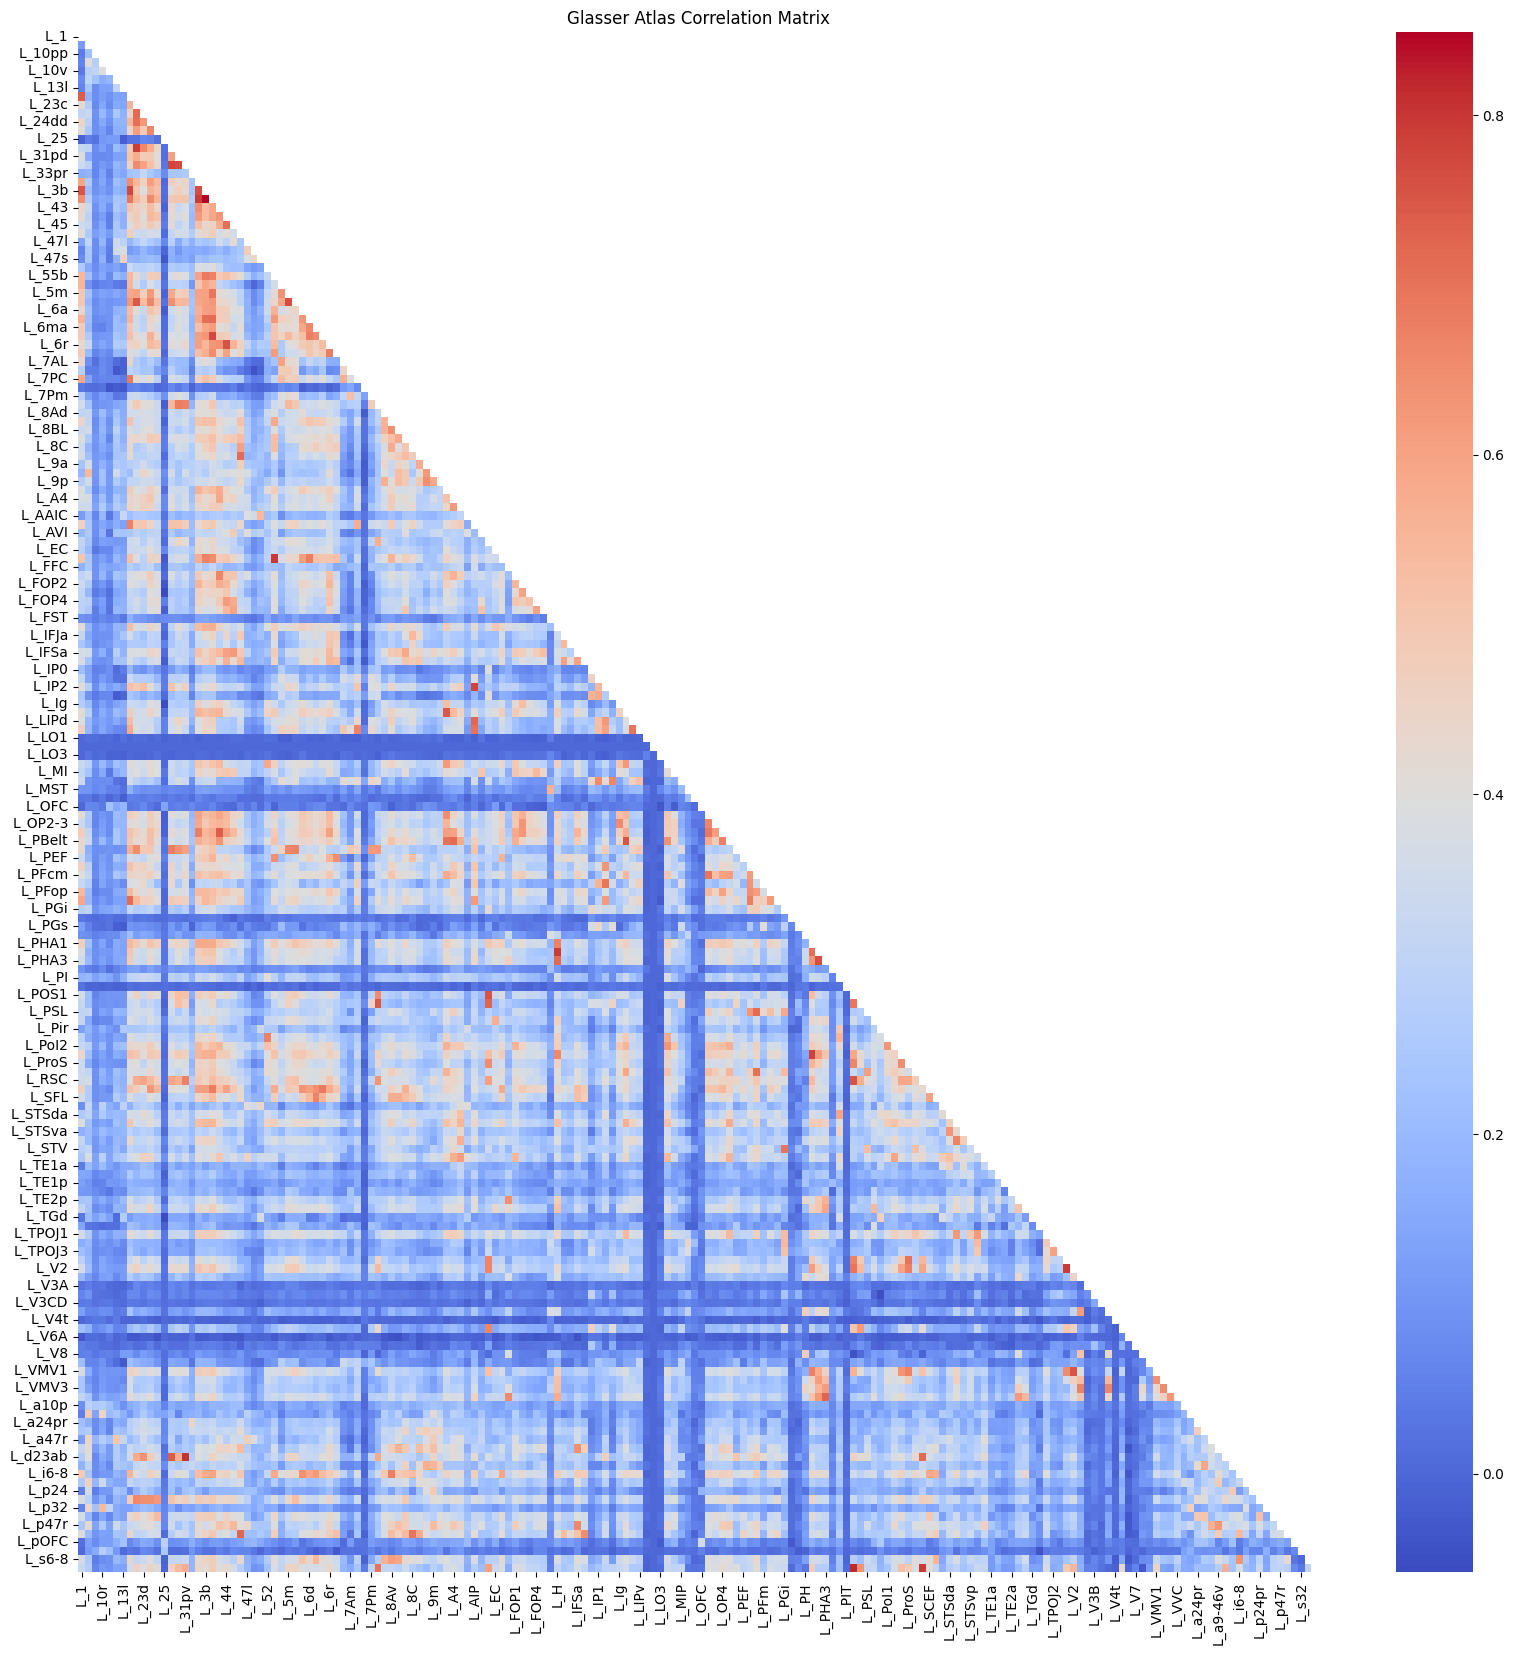

/tmp/ipykernel_27931/1343964931.py:48: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(matrixdiagNaN_abs.flatten()[~np.isnan(matrixdiagNaN_abs.flatten())],
/tmp/ipykernel_27931/1343964931.py:54: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log10(nonzero_vals), kde=False, ax=axes[1], norm_hist=

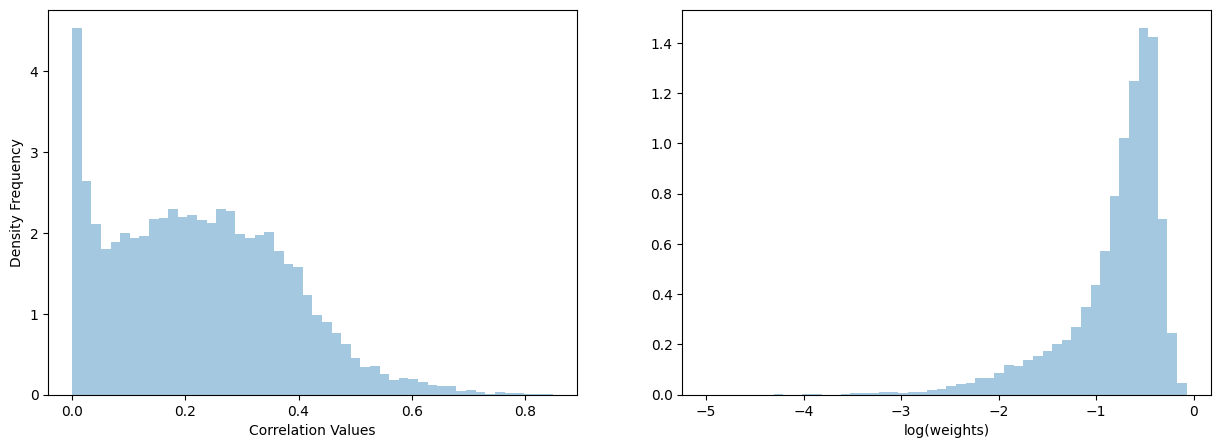


Network Metrics:
--------------------------------------------------
Network Density: 0.989
Mean Normalized Degree: 0.227

Calculating centrality measures...


/tmp/ipykernel_27931/1343964931.py:110: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list(closeness.values()), kde=False, ax=axes[0,0])
/tmp/ipykernel_27931/1343964931.py:114: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list(betweenness.values()), kde=False, ax=axes[0,1])
/tmp/ipykernel_27931

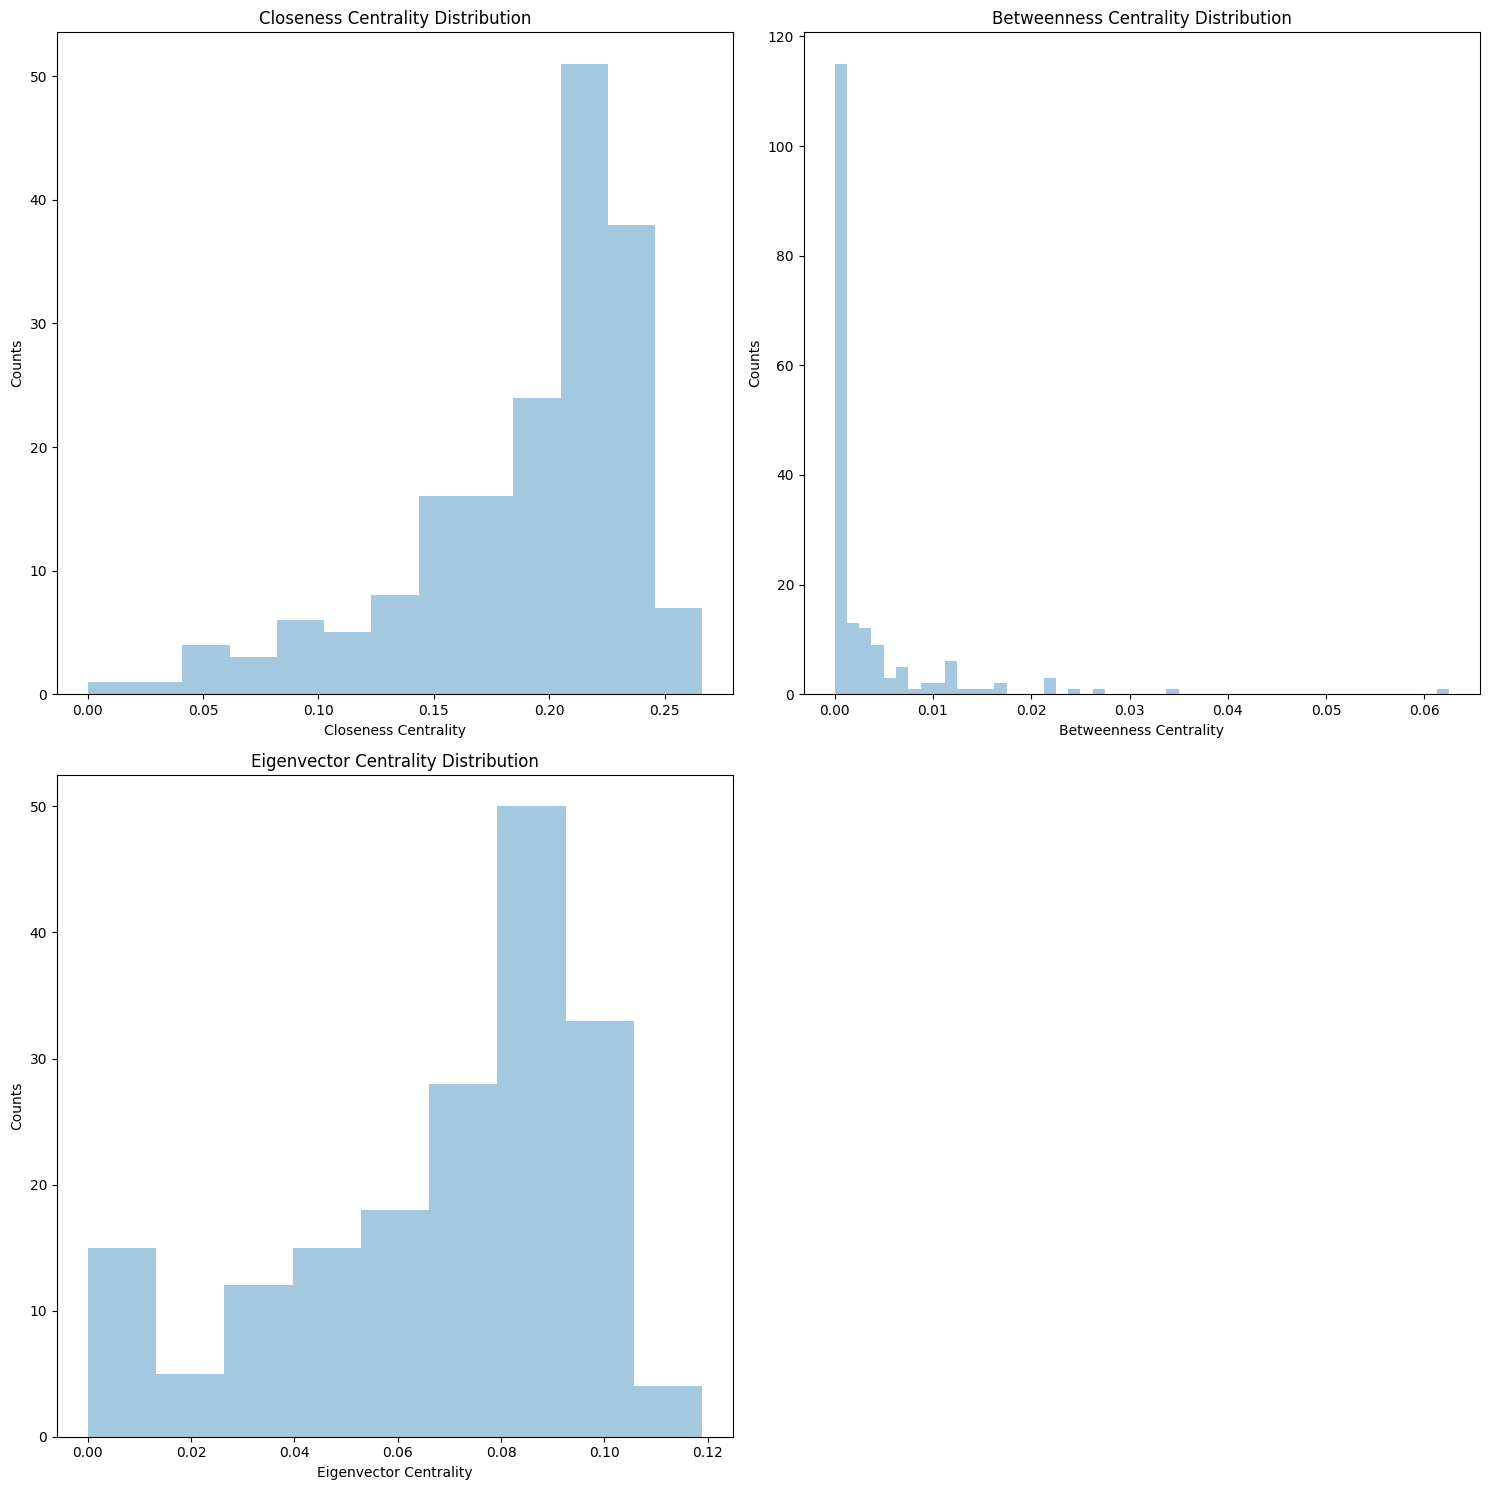


Saved network metrics to network_metrics_glasser.csv


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import logging

def analyze_brain_networks():
    # Set up directories
    curr_dir = '/user_data/csimmon2/git_repos/ptoc'
    results_dir = f'{curr_dir}/results'
    
    # Load matrices and labels
    mean_matrix = np.load(f'{results_dir}/connectivity_data/glasser_group_mean_matrix.npy')
    labels_path = f'{curr_dir}/glasser/HCP-MMP1_on_MNI152_ICBM2009a_nlin.txt'
    
    # Read Glasser labels
    with open(labels_path, 'r') as f:
        lineList = [line.split('_ROI')[0].split(' ', 1)[1] for line in f.readlines()]
    
    print(f"Matrix shape: {mean_matrix.shape}")
    print(f"Number of regions: {len(lineList)}")
    
    # Create and process correlation matrix DataFrame
    matrixdiagNaN = mean_matrix.copy()
    np.fill_diagonal(matrixdiagNaN, np.nan)
    Pdmatrix = pd.DataFrame(matrixdiagNaN)
    Pdmatrix.columns = lineList[:len(mean_matrix)]
    Pdmatrix.index = lineList[:len(mean_matrix)]
    Pdmatrix = Pdmatrix.sort_index(axis=0).sort_index(axis=1)
    
    # Plot correlation matrix heatmap
    plt.figure(figsize=(20, 20))
    mask = np.zeros_like(Pdmatrix.values, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(Pdmatrix, cmap='coolwarm', cbar=True, square=False, mask=mask)
    plt.title('Glasser Atlas Correlation Matrix')
    plt.show()
    
    # Distribution plots
    matrix_abs = np.abs(mean_matrix)
    matrixdiagNaN_abs = np.abs(matrixdiagNaN)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Raw weights distribution
    sns.distplot(matrixdiagNaN_abs.flatten()[~np.isnan(matrixdiagNaN_abs.flatten())], 
                kde=False, ax=axes[0], norm_hist=True)
    axes[0].set(xlabel='Correlation Values', ylabel='Density Frequency')
    
    # Log10 distribution
    nonzero_vals = matrixdiagNaN_abs.flatten()[~np.isnan(matrixdiagNaN_abs.flatten()) & (matrixdiagNaN_abs.flatten() > 0)]
    sns.distplot(np.log10(nonzero_vals), kde=False, ax=axes[1], norm_hist=True)
    axes[1].set(xlabel='log(weights)')
    plt.show()
    
    # Create NetworkX graph
    G = nx.from_numpy_array(matrix_abs)
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    
    # Calculate network metrics
    print("\nNetwork Metrics:")
    print("-" * 50)
    
    # Density
    density = nx.density(G)
    print(f"Network Density: {density:.3f}")
    
    # Node strength
    strength = G.degree(weight='weight')
    strengths = dict(strength)
    
    # Normalized strengths
    norm_strengths = {node: val * 1/(len(G.nodes)-1) for node, val in strength}
    
    # Mean degree
    mean_degree = np.mean(list(norm_strengths.values()))
    print(f"Mean Normalized Degree: {mean_degree:.3f}")
    
    # Calculate centrality measures
    print("\nCalculating centrality measures...")
    
    # Distance matrix for closeness/betweenness
    G_distance_dict = {(e1, e2): 1/abs(weight) for e1, e2, weight in G.edges(data='weight')}
    nx.set_edge_attributes(G, G_distance_dict, 'distance')
    
    try:
        # Closeness centrality
        closeness = nx.closeness_centrality(G, distance='distance')
        
        # Betweenness centrality
        betweenness = nx.betweenness_centrality(G, weight='distance')
        
        # Eigenvector centrality
        eigen = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
        
        # Store metrics
        metrics = {
            'Strength': strengths,
            'Normalized_Strength': norm_strengths,
            'Closeness': closeness,
            'Betweenness': betweenness,
            'Eigenvector': eigen
        }
        
        # Plot centrality distributions
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        
        sns.distplot(list(closeness.values()), kde=False, ax=axes[0,0])
        axes[0,0].set(xlabel='Closeness Centrality', ylabel='Counts')
        axes[0,0].set_title('Closeness Centrality Distribution')
        
        sns.distplot(list(betweenness.values()), kde=False, ax=axes[0,1])
        axes[0,1].set(xlabel='Betweenness Centrality', ylabel='Counts')
        axes[0,1].set_title('Betweenness Centrality Distribution')
        
        sns.distplot(list(eigen.values()), kde=False, ax=axes[1,0])
        axes[1,0].set(xlabel='Eigenvector Centrality', ylabel='Counts')
        axes[1,0].set_title('Eigenvector Centrality Distribution')
        
        axes[1,1].axis('off')  # Hide the fourth subplot
        plt.tight_layout()
        plt.show()
        
        # Save metrics to CSV
        metrics_df = pd.DataFrame({
            'Region': lineList[:len(mean_matrix)],
            'Strength': [strengths[i] for i in range(len(mean_matrix))],
            'Normalized_Strength': [norm_strengths[i] for i in range(len(mean_matrix))],
            'Closeness': [closeness[i] for i in range(len(mean_matrix))],
            'Betweenness': [betweenness[i] for i in range(len(mean_matrix))],
            'Eigenvector': [eigen[i] for i in range(len(mean_matrix))]
        })
        
        # Save to CSV
        metrics_df.to_csv(f'{results_dir}/network_metrics_glasser.csv', index=False)
        print("\nSaved network metrics to network_metrics_glasser.csv")
        
    except Exception as e:
        print(f"Error calculating network metrics: {e}")
        return

if __name__ == "__main__":
    analyze_brain_networks()

# Part 1. Network Analysis for Brain Connectivity Data
# Authors: [Your Name]

"""
This notebook adapts network and topological analysis methods for your brain connectivity data.
Working with data from the Glasser atlas and fMRI connectivity matrices.
"""

# Table of contents
# 1. Imports
# 2. Importing data & the connectivity matrix
# 3. Graph Theory
# 4. Topology & Geometry
# 5. References

# 1. Imports
# Basic data manipulation and visualization libraries

In [8]:
# Basic data manipulation and visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis 
import gudhi

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories
study_dir = f"/lab_data/behrmannlab/vlad/ptoc"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Magic command to change plotting backend
%matplotlib inline

# Possibility to stop warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 2. Importing data & the connectivity matrix

def load_connectivity_data(subject=None):
    """Load connectivity matrix data - either for a specific subject or group average"""
    if subject:
        matrix_path = f'{results_dir}/connectivity_matrices/{subject}_glasser_connectivity_matrix.npy'
    else:
        matrix_path = f'{results_dir}/connectivity_data/glasser_group_mean_matrix.npy'
    
    if not os.path.exists(matrix_path):
        raise FileNotFoundError(f"Matrix file not found: {matrix_path}")
    
    return np.load(matrix_path)

# Load the group average matrix for demonstration
matrix = load_connectivity_data()

# Load region names and network information
labels_path = f'{curr_dir}/glasser/HCP-MMP1_on_MNI152_ICBM2009a_nlin.txt'
with open(labels_path, 'r') as f:
    lineList = [line.rstrip('\n') for line in f]

# Load subnetwork information if available
try:
    sublist = [line.rstrip('\n') for line in open(f'{curr_dir}/subnet_ordernames.txt')]
    colorlist = [line.rstrip('\n') for line in open(f'{curr_dir}/subnet_order_colors.txt')]
    colornumbs = np.genfromtxt(f'{curr_dir}/subnet_colors_number.txt')
except FileNotFoundError:
    # Create dummy network assignments if files don't exist
    sublist = [f'Network_{i%5}' for i in range(len(lineList))]
    colorlist = ['#1f77b4'] * len(lineList)
    colornumbs = np.linspace(0, 1, len(lineList))

# Create a correlation matrix heatmap
Pdmatrix = pd.DataFrame(matrixdiagNaN)
Pdmatrix.columns = lineList
Pdmatrix.index = lineList
Pdmatrix = Pdmatrix.sort_index().sort_index(axis=1)  # Updated sorting syntax

# Plot heatmap
plt.figure(figsize=(20, 20))
_ = sns.heatmap(Pdmatrix, cmap='coolwarm', cbar=True, square=False)

# Weight distribution plots
bins = np.arange(np.sqrt(len(np.concatenate(matrix))))
bins = (bins - np.min(bins))/np.ptp(bins)
fig, axes = plt.subplots(1,2, figsize=(15,5))

# Distribution of raw weights
rawdist = sns.distplot(matrixdiagNaN.flatten(), bins=bins, kde=False, ax=axes[0], norm_hist=True)
rawdist.set(xlabel='Correlation Values', ylabel='Density Frequency')

# Probability density of log10
log10dist = sns.distplot(np.log10(abs(matrixdiagNaN)).flatten(), kde=False, ax=axes[1], norm_hist=True)
log10dist.set(xlabel='log(weights)')

In [13]:
# 3. Graph Theory


# Create the graph and remove self-loops
G = nx.from_numpy_matrix(matrix)
G.remove_edges_from(list(nx.selfloop_edges(G)))

# Compute network density
density = nx.density(G)
print(f"Network density: {density:.3f}")

# Compute node strength
strength = G.degree(weight='weight')
strengths = {node: val for (node, val) in strength}
nx.set_node_attributes(G, strengths, 'strength')

# Normalized node strength values
normstrengths = {node: val * 1/(len(G.nodes)-1) for (node, val) in strength}
nx.set_node_attributes(G, normstrengths, 'strengthnorm')

# Mean degree
normstrengthlist = np.array([val * 1/(len(G.nodes)-1) for (node, val) in strength])
mean_degree = np.sum(normstrengthlist)/len(G.nodes)
print(f"Mean degree: {mean_degree:.3f}")

# Compute centralities
# Distance dictionary for path-based metrics
G_distance_dict = {(e1, e2): 1 / abs(weight) for e1, e2, weight in G.edges(data='weight')}
nx.set_edge_attributes(G, G_distance_dict, 'distance')

# Closeness centrality
closeness = nx.closeness_centrality(G, distance='distance')
nx.set_node_attributes(G, closeness, 'closecent')

# Plot closeness centrality distribution
plt.figure(figsize=(8, 6))
sns.distplot(list(closeness.values()), kde=False, norm_hist=False)
plt.xlabel('Centrality Values')
plt.ylabel('Counts')
plt.title('Closeness Centrality Distribution')

# Betweenness centrality
betweenness = nx.betweenness_centrality(G, weight='distance')
nx.set_node_attributes(G, betweenness, 'bc')

# Plot betweenness centrality distribution
plt.figure(figsize=(8, 6))
sns.distplot(list(betweenness.values()), kde=False, norm_hist=False)
plt.xlabel('Centrality Values')
plt.ylabel('Counts')
plt.title('Betweenness Centrality Distribution')

# Eigenvector centrality
eigen = nx.eigenvector_centrality(G, weight='weight')
nx.set_node_attributes(G, eigen, 'eigen')

# Plot eigenvector centrality distribution
plt.figure(figsize=(8, 6))
sns.distplot(list(eigen.values()), kde=False, norm_hist=False)
plt.xlabel('Centrality Values')
plt.ylabel('Counts')
plt.title('Eigenvector Centrality Distribution')

# Compute average path length
avg_path_length = nx.average_shortest_path_length(G, weight='distance')
print(f"Average path length: {avg_path_length:.3f}")

# Compute modularity
part = community.best_partition(G, weight='weight')
print(f"Number of communities: {len(set(part.values()))}")

# Compute clustering coefficient
clustering = nx.clustering(G, weight='weight')
avg_clustering = nx.average_clustering(G, weight='weight')
print(f"Average clustering coefficient: {avg_clustering:.3f}")

# Network visualization
plt.figure(figsize=(30,30))
edgewidth = [d['weight'] for (u,v,d) in G.edges(data=True)]
pos = nx.spring_layout(G, scale=5)
nx.draw(G, pos, with_labels=True, 
        width=np.power(edgewidth, 2), 
        edge_color='grey', 
        node_size=normstrengthlist*20000,
        labels=dict(zip(range(len(lineList)), lineList)), 
        font_color='black', 
        node_color=colornumbs/10, 
        cmap=plt.cm.Spectral, 
        alpha=0.7, 
        font_size=9)

AttributeError: module 'networkx' has no attribute 'from_numpy_matrix'

In [ ]:
# 4. Topology & Geometry

# Compute persistent homology
mattop = 1 - matrix
rips_complex = gudhi.RipsComplex(distance_matrix=mattop, max_edge_length=1)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
diag = simplex_tree.persistence()

# Plot persistence barcode
gudhi.plot_persistence_barcode(diag, legend=True, max_intervals=0)
plt.title('Persistence Barcode')

# Plot persistence diagram
gudhi.plot_persistence_diagram(diag, legend=True, max_intervals=0)
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Birth', fontsize=15)
plt.ylabel('Death', fontsize=15)
plt.title('Persistence Diagram')

# Plot persistence density
gudhi.plot_persistence_density(diag, dimension=1)
plt.title('Persistence Density')

# 5. References
"""
References:

1. [Your references here]

Note: This notebook has been adapted for your specific data structure using paths:
- Base directory: /user_data/csimmon2/git_repos/ptoc
- Results directory: /user_data/csimmon2/git_repos/ptoc/results
- Atlas: Glasser atlas

Make sure all required files are in place before running the cells.
"""